# Gradient Descent and Loss Functions

Authors: [Alexander Wang](https://github.com/awang9999), [Winnie Chow](https://github.com/winnie0617)

<img src="images/header_picture.png" width=300 height=200 />

This module introduces the gradient descent algorithm for optimization and loss functions within the context of machine learning. This material is intended to be delivered on April 16, 2022 at a Cornell Data Science onboarding presentation, but is sufficient as standalone material as well.

Topics covered:
* Loss functions (MSE, MAE, Binary Cross Entropy, Hinge Loss)
* Gradient Descent (general algorithm and intuition, proof of convergence omitted)
* Gradient Descent variants (SGD, Mini-batched SGD)
* Brief discussion on Newton's method
* Example of applying gradient descent to solve the optimization problem for multidimensional linear regression (using MSE loss).

Associated slides for this presentation can be found [here](https://docs.google.com/presentation/d/1Er7sTuaL892dptan2unGSKmaC3BG7pKy8oNUIteFOhA/edit#slide=id.p).

In [1]:
import sys
print(sys.version)
# Require versions 3.7, 3.8 or 3.9

3.9.5 (default, Jan  2 2022, 22:23:27) 
[GCC 11.1.0]


## Part 1: Motivation

Up until now “training” models have largely been a black box. We talk about it all the time, but how do we REALLY adjust the parameters of a model? What is a good measure for how well a model predicts the training data? How do we adjust the model parameters based on the model’s performance in predicting the training data automatically?

This module aims to answer these questions.

## Part 2: Consider this problem

For the rest of this module, we will work on solving a linear regression problem in higher dimensions (i.e. dim > 1). First we generate a noisy 2 dimensional linearly distributed dataset. (I.e. it can be modeled by a plane)

In [2]:
import numpy as np

from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

np.random.seed(123)

In [3]:
# True target function
def f(x1, x2):
    return 0.15*x1 + 0.3*x2 + 0.2

In [4]:
def generate_data(n):
    Xs = np.zeros((n,2))
    # Uniformly random selection of points within [0,100]x[0,100]
    Xs[:,0] = np.random.uniform(-10, 10, n)
    Xs[:,1] = np.random.uniform(-10, 10, n)
    
    # Noise added to true target function
    ydelta = np.random.uniform(-1, 1, n)
    
    Ys = f(Xs[:,0], Xs[:,1]) + ydelta
    
    return Xs, Ys

In [5]:
Xs, Ys = generate_data(100)

We can visualize our dataset using a 3D plot. Indeed, it can be modelled by a plane.

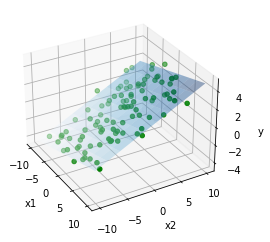

In [6]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(Xs[:,0], Xs[:,1], Ys, c='green')

x = np.linspace(-10, 10, 10)
y = np.linspace(-10, 10, 10)

X, Y = np.meshgrid(x, y)
Z = f(X, Y)

ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='Blues', edgecolor='none', alpha=0.4)

ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('y');
ax.view_init(30, -30)

### Part 2.1: Vector Calculus Review

The equation of a plane is given by

$$h(x_1, x_2) = w_1x_1 + w_2x_2 + b$$

where $w_1, w_2$ are the coefficients of the $x_1$ and $x_2$ variables respectively. $b$ can be thought of as the offset.
We can rewrite this in vector form as

$$ h(x) = \begin{bmatrix}w_1 & w_2\end{bmatrix} \begin{bmatrix}x_1 \\ x_2\end{bmatrix} + b = w^Tx + b$$

Note that vectors are conventionally column vectors in mathematics. This equation gives us a model for which we want to train for our particular dataset. In other words, can we recover $w$ and $b$ such that the plane "best" fits the generated dataset automatically? How can we define "best"?

## Part 3: Loss Functions

Loss functions compare a model's predictions to the true values given by the training dataset. They measure how much the predicted $y$ deviates from the true $y$ for all examples in the training dataset. For regression problems, the loss is usually some sort of aggregate error. For classification problems, the loss is usually some aggregate of misclassifications. We introduce a couple loss functions below:

#### Mean Squared Error (MSE)
$$\mathcal{L}(h,X,Y) = \frac{1}{n}\sum_{i=1}^n(h(x_i) - y_i)^2$$
* This loss is usually used for regression tasks.
* This loss function is differentiable everywhere.
* [link to wikipedia](https://en.wikipedia.org/wiki/Mean_squared_error)

In [7]:
def MSE_loss(h, X, Y):
    n = len(Y)
    loss = 1.0/n * sum((h(X) - Y)**2)
    return loss

#### Mean Absolute Error (MAE)
$$\mathcal{L}(h,X,Y) = \frac{1}{n}\sum_{i=1}^n|h(x_i) - y_i|$$
* This loss is usually used for regression tasks.
* This loss function is not differentiable at 0.
* [link to wikipedia](https://en.wikipedia.org/wiki/Mean_absolute_error)

In [8]:
def MAE_loss(h, X, Y):
    n = len(Y)
    loss = 1.0/n * np.sum(np.abs(h(X) - Y))
    return loss

#### Hinge Loss
$$\mathcal{L}(h,X,Y) = \frac{1}{n}\sum_{i=1}^n \max(0, 1-y_i h(x_i))$$
* This loss is usually used for classification tasks.
* This loss function is not differentiable at 0.
* [link to wikipedia](https://en.wikipedia.org/wiki/Hinge_loss)

In [9]:
def hinge_loss(h, X, Y):
    n = len(Y)
    loss = 1.0/n * np.sum(np.max(0,1- Y*h(X)))
    return loss

#### Binary Cross Entropy
$$\mathcal{L}(h,X,Y) = -\frac{1}{n}\sum_{i=1}^n (y_i\log(h(x)) + (1-y_i)\log(1-h(x))$$
* This loss is usually used for classification tasks
* This loss function is differentiable everywhere in its domain.
* $h(x)$ in this case returns a probability rather than an absolute class. (Specifically $h(x) = P(y=+1|x)$)
* [link to wikipedia](https://en.wikipedia.org/wiki/Cross_entropy)

In [10]:
def BCE_loss(h, X, Y):
    n = len(Y)
    loss = -1.0/n * np.sum(Y*np.log(h(X)) + (1-Y)*np.log(1-h(X)))
    return loss

These loss functions are just a small selection of the commonly used ones. Each loss function has advantages and disadvantages, for which wikipedia provides a much more rigorous treatment. Now we have established a few methods to evaluate the quality of a model on the training dataset. A lower loss for a particular model implies that model fits the training dataset better. (I.e. the performance of a model is inversely proportional to its loss.) How can we use these metrics to recover the optimal $w$ and $b$ in our problem?

## Part 4: Regression
You may recognize this as a multidimensional linear regression problem: given $X$s and $Y$s, find $w$ and $b$ such that $h(x) = wx + b$ best models the dataset $(X,Y)$. The convention for this problem is to use mean squared error (MSE) as a loss function. We formulate the following criterion, for which we want to optimize (I.e. find the minimum):

$$\begin{align*}
    \arg\min_{w,b} \mathcal{L}(w,b) &= \arg\min_{w,b} \frac{1}{2n}\sum_{i=1}^n((w^Tx_i + b) - y_i)^2 \\
    &= \arg\min_{w,b} \frac{1}{2n}(\dot{X}(b \; w)-Y)^T(\dot{X}(b \; w)-Y) \\
    &= \arg\min_{\theta} \frac{1}{2n} (\dot{X}\theta-Y)^T(\dot{X}\theta-Y)
\end{align*}$$
where $\theta = (b \; w)$, $\dot{x}_i = (1 \; x_i)^T$ and $\dot{X}$ is produced analogously.

There exists an analytical solution for the optimal $w$ and $b$, that is:

$$\theta^* = (\dot{X}^T \dot{X})^{-1}\dot{X}^T Y$$

$$w^* = \theta^*[1:]$$

$$b^* = \theta^*[0]$$

where $\bar{x}$ and $\bar{y}$ represents the mean value of $X$ and $Y$ respectively. (The derivation for this solution is outside the scope of this discussion, but contact the authors if you're interested! [reference](https://towardsdatascience.com/analytical-solution-of-linear-regression-a0e870b038d5))

Although there is a closed form analytical solution to optimizing our model (multidimensional linear regression) this is RARELY the case in practice. Most models do not have a closed form analytical solution. Moreover, computing the analytical solution may be slow (if it is even possible) especially for more complicated problems. Nevertheless, we write code to compute the analytical solution to produce a "target" for the iterative methods introduced below, that is, gradient descent.

In [11]:
from numpy.linalg import inv

n = len(Ys)
zeros = np.ones((n, 1))
Xdots = np.hstack((zeros,Xs))

def multidim_linear_regression(X, Y):
    theta = inv(X.T @ X) @ (X.T @ Y)
    
    w = theta[1:]
    b = theta[0]
    return w, b

In [12]:
w_analytical, b_analytical = multidim_linear_regression(Xdots, Ys)
print(f'The analytical regression solution is h(x) = {w_analytical}^T * x + ({b_analytical}).')

The analytical regression solution is h(x) = [0.14988658 0.31034988]^T * x + (0.17628087843275853).


## Part 5: Gradient Descent

So how can we find the minimum of a function? If we recall from calculus, there exist analytical methods to do so...(set derivative equal zero and solve derivatives for optimization variables, lagrange multipliers, etc). In practice, these methods rarely work because some functions cannot be solved analytically (ex. $x^4 + x^5 + x^6 + log(x + x^5) = 0$).

We can use an iterative method to approximate local minima: gradient descent. Recall that the gradient of a function is the direction of steepest ascent (proven in multivariable calculus). What if we start from a random point and move slightly in the direction of steepest descent?

### Gradient Descent Algorithm

Given a loss function $\mathcal{L}$, a parameter to optimize $w$, a maximum number of iterations $T$, and a step size $\eta_t$ (allowed to depend on $t$, will be discussed later), we give the following algorithm for optimizing $w$:

Initialize $w^{(0)} = (0,...,0)$.

For $t = 1, 2, 3, ..., T$:

$$w^{(t+1)} \leftarrow w^{(t)} - \eta_t \nabla \mathcal{L}(w^{(t)})$$

Output $w^{(T)}$.

<img src="images/gd_animation.gif" width=512 height=384 />

Here, we give an implementation of gradient descent and apply it to solve our problem. Recall the loss function of our problem after wrapping $w$ and $b$ into a single parameters variable $\theta$:

$$ \mathcal{L}(\theta) = \frac{1}{2n} (\dot{X}\theta-Y)^T(\dot{X}\theta-Y) $$

The gradient of this loss function is:

$$\frac{\partial \mathcal{L}(\theta)}{\partial \theta} = \frac{1}{n}(\dot{X}^T\dot{X} \theta - \dot{X}^TY)$$

(derivation omitted). Then we can write the code for gradient descent in our problem.

In [13]:
def least_squares(theta, X, Y):
    n = len(Y)
    X_theta = X @ theta
    X_theta_minus_Y = X_theta - Y
    
    loss = 1/(2.0*n) * ((X_theta_minus_Y).T @ X_theta_minus_Y)
    grad = 1.0/n * (X.T @ (X_theta) - (X.T @ Y)) 
    
    return loss, grad

In [14]:
def gradient_descent(func, X, Y, max_iter=2000, lr=0.001, delta=1e-02):
    
    d = len(X[0])
    
    losses = np.zeros(max_iter)
    grad = np.zeros(d)
    theta = np.random.rand(d)
    
    for t in range(max_iter):
        losses[t], grad = func(theta, X, Y)
        theta -= lr * grad
        if np.linalg.norm(grad) < delta:
            print('converged before max_iters')
            losses = losses[:t+1]
            break
    
    w_opt = theta[1:]
    b_opt = theta[0]
    
    return losses, w_opt, b_opt

In [15]:
losses_gd, w_gd, b_gd = gradient_descent(least_squares, Xdots, Ys)
print(f'The gradient descent solution is h(x) = {w_gd}^T * x + ({b_gd}) with \n loss {losses_gd[-1]}')

The gradient descent solution is h(x) = [0.14992155 0.31042314]^T * x + (0.15466098566265207) with 
 loss 0.1926990196347717


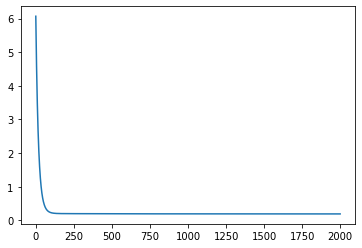

In [16]:
iters = range(len(losses_gd))
plt.plot(iters, losses_gd)
plt.show()

We see that the recovered function is close to the generating function $f(x) = 0.15x_1 + 0.3x_2 + 0.2$ with a bit of noise which is what we expect since the data does is not exactly linear. Also notice that the final loss of gradient descent is not too far off of the loss produced by the analytically optimal parameters:

In [17]:
loss, _ = least_squares([b_analytical, w_analytical[0], w_analytical[1]], Xdots, Ys)
loss

0.19246493047925736

As good as gradient descent is, there are still numerous potential issues with it in its current form:
* It might not find the global minimum
    * It can get stuck in a local minimum    
    * It might keep overshooting the minimum if $\eta_t$ is too large.
* Non-deterministic (starting point is arbitrary/random)
* Computationally expensive for large datasets
* Takes many iterations to converge (if at all)

<img src="images/local_minima.png" width=212 height=166 />

<img src="images/overshooting.png" width=600 height=150 />

## Part 6: Variations of Gradient Descent

One of the pitfalls of gradient descent is the computational cost of running it on large datasets. For each iteration, we compute the gradient of each training example and take the average. What if we only computed the gradient of one training example at each step?

#### Stochastic Gradient Descent (SGD)

Initialize $w^{(0)} = (0,...,0)$.

For $t = 1, 2, 3, ..., T$:

Choose $x_i, y_i$ randomly among $X, Y$.

$$w^{(t+1)} \leftarrow w^{(t)} - \eta_t \nabla \mathcal{L}(w^{(t)}, x_i, y_i)$$

Output $w^{(T)}$.

This algorithm leverages the fact that we can evaluate the loss only at one randomly chosen example to get an estimate of the real loss. Then, the expectation of the gradient (only evaluated at one element) among many iterations is, roughly speaking, the real gradient.

* Advantage: Evaluate loss function  only on one sample
* Advantage: Much more efficient, and might help overcome local minima
* Disadvantage: Might take (many) more iterations / does not converge at all

<img src="images/sgd_animation.gif" width=512 height=384 />

#### Mini-Batch Gradient Descent

Initialize $w^{(0)} = (0,...,0)$.

For $t = 1, 2, 3, ..., T$:

Choose $X_{batch}, Y_{batch}$, a subset of $X, Y$, randomly.

$$w^{(t+1)} \leftarrow w^{(t)} - \eta_t \nabla \mathcal{L}(w^{(t)}, X_{batch}, Y_{batch})$$

Output $w^{(T)}$.

Similar to SGD, mini-batched gradient descent only evaluates the loss for a (small) subset of the total examples.

* Advantage: Evaluate loss function on a subset of samples.
* Mid-vantage: The medium between SGD and pure gradient descent, effectively the best of both worlds.

#### Adagrad

Given step size parameter $\alpha > 0$, tolerance $\delta > 0$ and a small number $\epsilon > 0$:

Initialize $w = (0,...,0)$ and $z = (0,...,0)$.

Repeat until converged:

$ g = \nabla \mathcal{L}(w^{(t)})$ # compute gradient

for all $i \in {1, ..., d}$, set $z_d \leftarrow z_d + g_d^2$

for all $i \in {1, ..., d}$, update $w_d \leftarrow w_d - \alpha \frac{g_d}{\sqrt{z_d + \epsilon}}$

If $\|w^{(t+1)} - w^{(t)}\| \leq \delta$, converged!

Output $w$.

This algorithm works the same as gradient descent except it sets the learning rate adaptively for every feature.

* Advantage: adaptive gradients for each feature
* Advantage: high learning rate for features with small gradients, low learning rates for features with large gradients. 
* Disadvantage: Still computes gradient for every example
* Disadvantage: Introduces additional computations on the order of magnitude of the dimensions of the problem.

Adagrad works very well in practice, so we include an implementation of it for our regression problem. Feel free to reference back to this if needed.

In [18]:
def adagrad(func, alpha, X, Y, maxiter=1000,delta=1e-02):
    d = len(X[0])
    
    losses = np.zeros(maxiter)
    eps = 1e-06
    
    theta = np.random.rand(d)
    grad = np.zeros(d)
    z = np.zeros(d)
    
    for i in range(maxiter):
        losses[i], grad = func(theta, X, Y)
        #print(losses[i])
        z += grad ** 2
        theta -= alpha * grad / np.sqrt(z + eps)
        if np.linalg.norm(grad) < delta: 
            losses = losses[:i+1]
            break
    
    w_opt = theta[1:]
    b_opt = theta[0]
    
    return losses, w_opt, b_opt

In [19]:
losses_ada, w_ada, b_ada = adagrad(least_squares, 1, Xdots, Ys)
print(f'The gradient descent solution is h(x) = {w_ada}^T * x + ({b_ada}) with \n loss {losses_ada[-1]}')

The gradient descent solution is h(x) = [0.14984928 0.31046869]^T * x + (0.17631999570222162) with 
 loss 0.1924658665636941


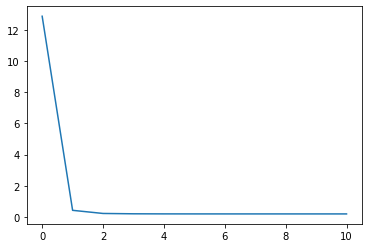

In [21]:
iters = range(len(losses_ada)-1)
plt.plot(iters, losses_ada[1:])
plt.show()

Here is a visualization for the rate of convergence for SGD, Momentum, RMSProp, and Adam (all additional gradient descent variants) from the Intelligent Systems subteam onboarding materials:
* Enter root folder of this project
* Enter interactive_gd
* Open variants_visual.html

## References

* https://towardsdatascience.com/analytical-solution-of-linear-regression-a0e870b038d5
* https://www.cs.cornell.edu/courses/cs4780/2022sp/notes/LectureNotes11.html
* https://www.cs.cornell.edu/courses/cs4780/2022sp/notes/LectureNotes12.html
* https://www.cs.cornell.edu/courses/cs4780/2022sp/notes/LectureNotes14.html